In [35]:
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time

[nltk_data] Downloading package punkt to /Users/zach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/zach/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [42]:
max_jobs = 200
title = '"Data Scientist"'
location = 'United States'

def make_urls(job_title, location, max_jobs):
    base_url = 'https://www.indeed.com/jobs?'
    num_pages = max_jobs // 10
    job_title = job_title.replace(' ', '+')
    location = location.replace(' ', '+')
    urls = []
    for p in range(num_pages):
        url = base_url + 'q=' + job_title + '&l=' + location + '&start=' + str(p * 10)
        urls.append(url)
    return urls

In [43]:
def get_listings(job_title, location, max_jobs):
    listings = []
    urls = make_urls(job_title, location, max_jobs)
    
    for url in urls:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        listings.extend([s.text for s in soup.findAll(class_='summary')])
        time.sleep(1)
    return list(set(listings)) # return a set because indeed.com duplicates listings

jobs = get_listings(title, location, max_jobs)

In [46]:
jobs[0]

'\n                            As a Data Scientist at NSA, responsibilities may include:. Data Scientists are hired into positions directly supporting a technical mission office or the Data...'

## 2) Use NLTK to tokenize / clean the listings 

In [53]:
stop_words = stopwords.words('english')

def tokenize_jobs(jobs):
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    jobs = [j.translate(table) for j in jobs]
    # tokenize words
    return [word_tokenize(j) for j in jobs]

tokens = tokenize_jobs(jobs)

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [55]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# lemmatize
lemmatizer = WordNetLemmatizer()
lemmatized_jobs = []
for listing in tokens:
    lemmas = [lemmatizer.lemmatize(word) for word in listing]
    lemmatized_jobs.append(lemmas)

[nltk_data] Downloading package wordnet to /Users/zach/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
# count vectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
counts = []
for j in lemmatized_jobs:
    vectorizer.fit(j)
    counts.append(vectorizer.vocabulary_)
counts

[{'data': 0,
  'scientist': 9,
  'nsa': 5,
  'responsibility': 8,
  'include': 3,
  'scientists': 10,
  'hired': 2,
  'position': 7,
  'directly': 1,
  'supporting': 11,
  'technical': 12,
  'mission': 4,
  'office': 6},
 {'ideal': 8,
  'data': 2,
  'scientist': 11,
  'ha': 6,
  'handson': 7,
  'experience': 5,
  'developing': 3,
  'science': 10,
  'solution': 12,
  'ability': 0,
  'communicate': 1,
  'effectively': 4,
  'nontechnical': 9,
  'stakeholder': 13},
 {'creates': 0,
  'new': 7,
  'data': 1,
  'product': 8,
  'derive': 2,
  'information': 4,
  'looking': 6,
  'fulltime': 3,
  'scientist': 10,
  'salem': 9,
  'location': 5},
 {'35': 0,
  'year': 13,
  'experience': 6,
  'building': 3,
  'large': 8,
  'data': 5,
  'set': 11,
  'multiple': 9,
  'source': 12,
  'build': 2,
  'algorithm': 1,
  'predicting': 10,
  'future': 7,
  'characteristic': 4},
 {'create': 1,
  'graphic': 6,
  'data': 2,
  'visualization': 11,
  'information': 8,
  'display': 3,
  'experience': 5,
  'healthca

# 4) Visualize the most common word counts

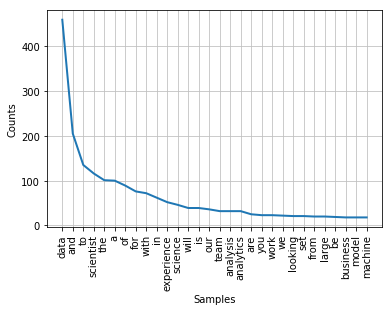

In [62]:
all_jobs = []
for j in lemmatized_jobs:
    for w in j:
        all_jobs.append(w.lower())
fdist = FreqDist(all_jobs)

fdist.plot(30, cumulative=False)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [75]:
tfidf = TfidfVectorizer(max_features=50, ngram_range=(1,2))

jobs_input = []
for l in lemmatized_jobs:
    s = ''
    for w in l:
        if w not in stopwords.words('english'):
            s += ' ' + w
    jobs_input.append(s)

feature_matrix = tfidf.fit_transform(jobs_input)
# Get feature names to use as dataframe column headers
feature_names = tfidf.get_feature_names()

# View Feature Matrix as DataFrame
df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
df.head()

,analysis,analytics,as,big,big data,build,business,client,data,data analysis,...,team,the,the data,tool,using,visualization,we,we looking,work,year
0,0.0,0.0,0.683762,0.0,0.0,0.00000,0.0,0.0,0.580111,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000
1,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.339398,0.0,...,0.0,0.463973,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000
2,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.329479,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.342979,0.380544,0.0,0.0000
3,0.0,0.0,0.000000,0.0,0.0,0.39943,0.0,0.0,0.216128,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.3606
4,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.333237,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.601958,0.000000,0.000000,0.0,0.0000


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.